# EDA y Desarrollo de Modelo

### Importamos las librerías necesarias

In [177]:

#Manipulación, limpieza y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Preparación de datos y features
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Modelos a utilizar
from sklearn.linear_model import LogisticRegression


#Evaluación de modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

#Exportación del modelo
import pickle


In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cargamos el dataset y limpiamos

In [179]:
#Cargamos el dataset
df = pd.read_csv('/content/drive/MyDrive/Nala/DS Challenge.csv', sep = ';')

df.sample(5)

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
7052,1077,--,"928,2021424",4/01/2020,9,{'model': 2020; 'device_score': 4; 'os': 'WEB'},Super,NaN,Virtual,37000,32,Aceptada,False,0,"18,56404285",False
8684,1303,M,"758,262483",20/01/2020,16,{'model': 2020; 'device_score': 2; 'os': 'ANDR...,Restaurante,Toluca,FÃ­sica,72000,64,Aceptada,False,0,"7,58262483",False
22666,3359,--,"124,7064666",5/01/2020,3,{'model': 2020; 'device_score': 1; 'os': 'ANDR...,NaN,Guadalajara,FÃ­sica,82000,44,Aceptada,False,"12,47064666","1,122358199",False
6909,1061,M,"705,0160104",24/01/2020,19,{'model': 2020; 'device_score': 5; 'os': '%%'},NaN,Guadalajara,FÃ­sica,96000,43,Aceptada,False,0,"7,050160104",False
15779,2331,M,"63,98652174",28/01/2020,5,{'model': 2020; 'device_score': 4; 'os': '%%'},NaN,Toluca,FÃ­sica,98000,61,En proceso,True,"6,398652174","0,575878696",False


In [180]:
#Dividimos la columna de dispositivos
device_cols = df['dispositivo'].str.split(';', n = 2).apply(pd.Series)

device_cols

,0,1,2
0,{'model': 2020,'device_score': 3,'os': 'ANDROID'}
1,{'model': 2020,'device_score': 1,'os': 'ANDROID'}
2,{'model': 2020,'device_score': 1,"'os': ','}"
3,{'model': 2020,'device_score': 3,'os': 'WEB'}
4,{'model': 2020,'device_score': 3,'os': '%%'}
...,...,...,...
26970,{'model': 2020,'device_score': 2,'os': 'ANDROID'}
26971,{'model': 2020,'device_score': 2,'os': 'WEB'}
26972,{'model': 2020,'device_score': 2,'os': 'WEB'}
26973,{'model': 2020,'device_score': 5,"'os': ','}"


In [181]:
#Renombramos columnas
device_cols = device_cols.rename(columns = {0: 'device_model', 1: 'device_score', 2: 'device_os'})

device_cols

,device_model,device_score,device_os
0,{'model': 2020,'device_score': 3,'os': 'ANDROID'}
1,{'model': 2020,'device_score': 1,'os': 'ANDROID'}
2,{'model': 2020,'device_score': 1,"'os': ','}"
3,{'model': 2020,'device_score': 3,'os': 'WEB'}
4,{'model': 2020,'device_score': 3,'os': '%%'}
...,...,...,...
26970,{'model': 2020,'device_score': 2,'os': 'ANDROID'}
26971,{'model': 2020,'device_score': 2,'os': 'WEB'}
26972,{'model': 2020,'device_score': 2,'os': 'WEB'}
26973,{'model': 2020,'device_score': 5,"'os': ','}"


In [182]:
#Las incorporamos al dataset
df = pd.concat([df, device_cols], axis = 1)

In [183]:
#Inspeccionamos con una muestra aleatoria que se hayan agregado correctamente
df.sample(5)

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os
20912,3086,F,"653,2365953",4/01/2020,18,{'model': 2020; 'device_score': 2; 'os': 'WEB'},NaN,NaN,FÃ­sica,51000,53,Aceptada,False,0,"6,532365953",False,{'model': 2020,'device_score': 2,'os': 'WEB'}
1172,186,M,"415,0995484",2/01/2020,22,{'model': 2020; 'device_score': 1; 'os': '%%'},Restaurante,Toluca,Virtual,54000,48,Aceptada,False,0,"8,301990968",False,{'model': 2020,'device_score': 1,'os': '%%'}
19986,2939,--,"115,4407909",14/01/2020,13,{'model': 2020; 'device_score': 2; 'os': '%%'},Super,Toluca,FÃ­sica,47000,50,Aceptada,False,0,"1,154407909",False,{'model': 2020,'device_score': 2,'os': '%%'}
7778,1191,F,"823,6252511",16/01/2020,15,{'model': 2020; 'device_score': 1; 'os': '%%'},NaN,Merida,FÃ­sica,72000,43,En proceso,False,0,"8,236252511",False,{'model': 2020,'device_score': 1,'os': '%%'}
8583,1289,M,"300,6500588",13/01/2020,8,{'model': 2020; 'device_score': 4; 'os': 'WEB'},NaN,Guadalajara,FÃ­sica,76000,46,Rechazada,False,0,"3,006500588",False,{'model': 2020,'device_score': 4,'os': 'WEB'}


In [184]:
#Sacamos las columnas que no utilizaremos
df.drop(columns = ['dispositivo', 'ID_USER'],inplace = True, index = 1)

In [185]:
#Comprobamos
df.head()

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os
0,F,"608,3456335",21/01/2020,20,Super,Merida,FÃ­sica,71000,51,Aceptada,False,"60,83456335","5,475110702",False,{'model': 2020,'device_score': 3,'os': 'ANDROID'}
2,F,"790,0376533",17/01/2020,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0,"15,80075307",False,{'model': 2020,'device_score': 1,"'os': ','}"
3,F,"767,0053873",5/01/2020,11,MPago,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"7,670053873",False,{'model': 2020,'device_score': 3,'os': 'WEB'}
4,F,"254,1710526",30/01/2020,10,NaN,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"2,541710526",False,{'model': 2020,'device_score': 3,'os': '%%'}
5,F,"37,00374724",27/01/2020,3,NaN,Guadalajara,FÃ­sica,94000,56,Rechazada,False,0,"0,370037472",False,{'model': 2020,'device_score': 2,'os': '%%'}


In [186]:
#Limpiamos nuestras nuevas columnas para ser analizadas más fácilmente
df['device_model'] = df['device_model'].map(lambda x: x.lstrip("{'model':"))
df['device_score'] = df['device_score'].map(lambda x: x.replace("'device_score':",""))
df['device_os'] = df['device_os'].map(lambda x: x.lstrip("'os': '").rstrip("'}"))

df['device_score'] = df['device_score'].astype(int)

In [187]:
#Cambiamos comas por puntos, para mejor manipulación posteriormente
df['cashback'] = df['cashback'].map(lambda x: x.replace(",","."))
df['dcto'] = df['dcto'].map(lambda x: x.replace(",","."))
df['monto'] = df['monto'].map(lambda x: x.replace(",","."))

In [188]:
#Cambiamos tipos de variables
df['cashback'] = df['cashback'].astype(float)
df['dcto'] = df['dcto'].astype(float)
df['monto'] = df['monto'].astype(float)

In [189]:
#Sustituimos
df['tipo_tc'] = df['tipo_tc'].str.replace('FÃ­sica', 'Fisica')

In [190]:
#Ajustamos columna de fecha y creamos columnas para mes y año
df['fecha'] = df['fecha'].astype('datetime64[ns]')
df['mes'] = pd.DatetimeIndex(df['fecha']).month
df['año'] = pd.DatetimeIndex(df['fecha']).year

In [191]:
#Revisamos que no hayan valores anormales
print(df.mes.sort_values().unique())
print(df.año.sort_values().unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12]
[2020]


In [192]:
#Comprobamos que todo esté bien con una muestra aleatoria
df.sample(5)

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os,mes,año
8012,M,148.160098,2020-07-01,2,Super,Merida,Fisica,39000,53,Aceptada,True,14.816010,1.333441,False,2020,1,",",7,2020
7088,F,447.215473,2020-02-01,18,Abarrotes,NaN,Fisica,89000,54,Aceptada,False,0.000000,4.472155,False,2020,2,%%,2,2020
10338,F,549.717044,2020-01-20,22,MPago,Guadalajara,Fisica,54000,46,Aceptada,False,0.000000,5.497170,False,2020,5,",",1,2020
4978,M,153.724506,2020-01-17,8,Restaurante,Monterrey,Fisica,87000,37,Aceptada,False,0.000000,1.537245,False,2020,3,%%,1,2020
9911,M,306.590886,2020-12-01,19,NaN,NaN,Fisica,83000,53,Aceptada,False,30.659089,2.759318,False,2020,1,WEB,12,2020


In [193]:
#Revisamos si hay valores vacíos, estos features no serán incorporados en nuestro modelo
df.isnull().sum()

genero                 0
monto                  0
fecha                  0
hora                   0
establecimiento    10118
ciudad             11678
tipo_tc                0
linea_tc               0
interes_tc             0
status_txn             0
is_prime               0
dcto                   0
cashback               0
fraude                 0
device_model           0
device_score           0
device_os              0
mes                    0
año                    0
dtype: int64

In [194]:
#Revisamos nuestros tipos de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26974 entries, 0 to 26974
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   genero           26974 non-null  object        
 1   monto            26974 non-null  float64       
 2   fecha            26974 non-null  datetime64[ns]
 3   hora             26974 non-null  int64         
 4   establecimiento  16856 non-null  object        
 5   ciudad           15296 non-null  object        
 6   tipo_tc          26974 non-null  object        
 7   linea_tc         26974 non-null  int64         
 8   interes_tc       26974 non-null  int64         
 9   status_txn       26974 non-null  object        
 10  is_prime         26974 non-null  bool          
 11  dcto             26974 non-null  float64       
 12  cashback         26974 non-null  float64       
 13  fraude           26974 non-null  bool          
 14  device_model     26974 non-null  objec

### Análisis Exploratorio de Datos

In [195]:
#Vemos nuestras variables numéricas
numeric_cols = df._get_numeric_data()

numeric_cols.head()

,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,device_score,mes,año
0,608.345633,20,71000,51,False,60.834563,5.475111,False,3,1,2020
2,790.037653,11,94000,56,False,0.000000,15.800753,False,1,1,2020
3,767.005387,11,94000,56,False,0.000000,7.670054,False,3,5,2020
4,254.171053,10,94000,56,False,0.000000,2.541711,False,3,1,2020
5,37.003747,3,94000,56,False,0.000000,0.370037,False,2,1,2020


In [196]:
#Y comenzamos a ver algunas estadísticas 
numeric_cols.describe()

,monto,hora,linea_tc,interes_tc,dcto,cashback,device_score,mes,año
count,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.000000,26974.0
mean,499.084705,11.987803,62476.495885,48.224772,17.466782,6.261352,3.002669,3.270816,2020.0
std,289.304091,6.642619,21887.237089,9.587418,34.335038,4.458439,1.417406,3.504380,0.0
min,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138,1.000000,1.000000,2020.0
25%,246.525092,6.000000,44000.000000,40.000000,0.000000,2.792318,2.000000,1.000000,2020.0
50%,500.520141,12.000000,62000.000000,48.000000,0.000000,5.636734,3.000000,1.000000,2020.0
75%,749.598774,18.000000,82000.000000,57.000000,18.777996,8.531822,4.000000,5.000000,2020.0
max,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582,5.000000,12.000000,2020.0


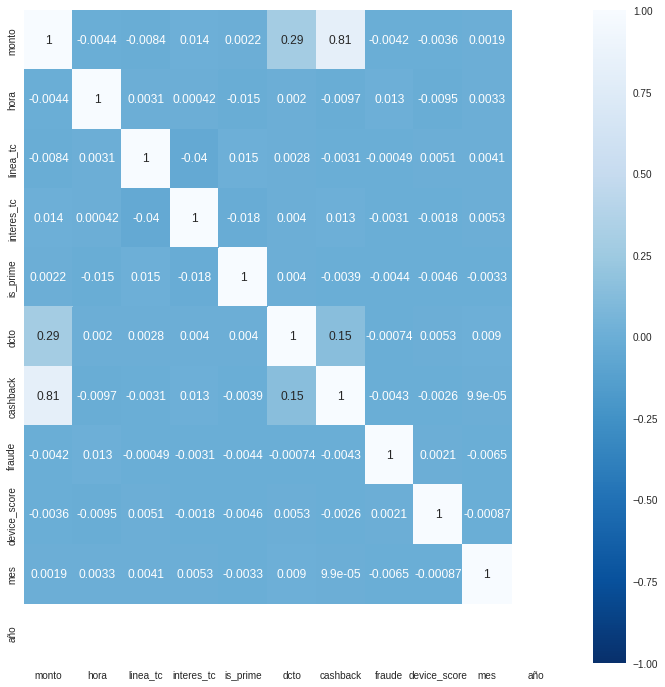

In [197]:
#Observamos si existe alguna correlación en nuestros datos
fig, ax = plt.subplots()
fig.set_size_inches(12,12)

sns.heatmap(numeric_cols.corr(), vmin=-1, vmax=1, annot=True, cmap = 'Blues_r')

No parece haber correlaciones significativas en nuestras variables, salvo entre monto y cashback. Esto no parece indicar uque sean variables de interés para nuestro análisis y/o modelo, sino un indicio de que los datos en nuestro dataset tienen sentido.

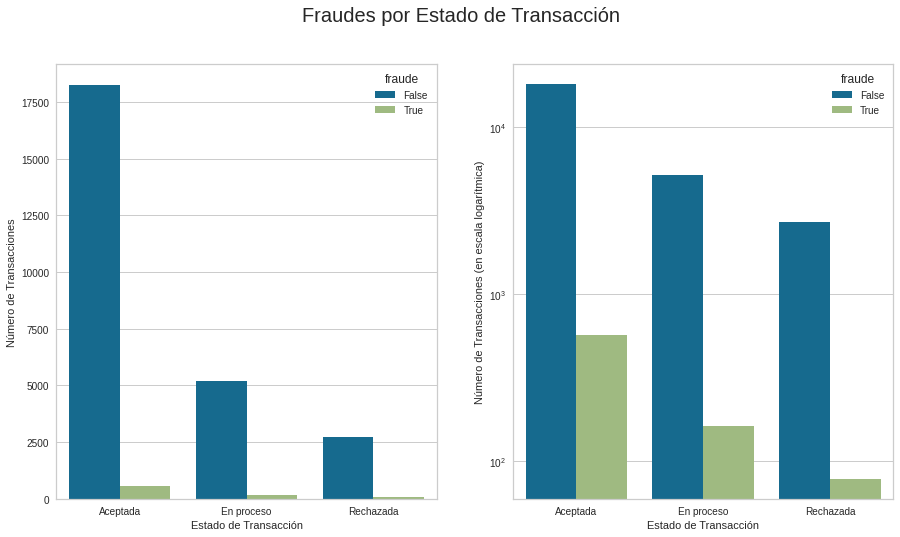

In [198]:
#Observamos la distribución de transacciones fraudulentas por estado de transacción
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

plt.subplot(1,2,1)
status_txn_1 = sns.countplot(data = df, x = 'status_txn', hue = 'fraude')
plt.xlabel('Estado de Transacción')
plt.ylabel('Número de Transacciones')

plt.subplot(1,2,2)
status_txn_2 = sns.countplot(data = df, x = 'status_txn', hue = 'fraude')
status_txn_2.set_yscale('log')
plt.xlabel('Estado de Transacción')
plt.ylabel('Número de Transacciones (en escala logarítmica)')


plt.suptitle('Fraudes por Estado de Transacción', size = 20)
plt.show()

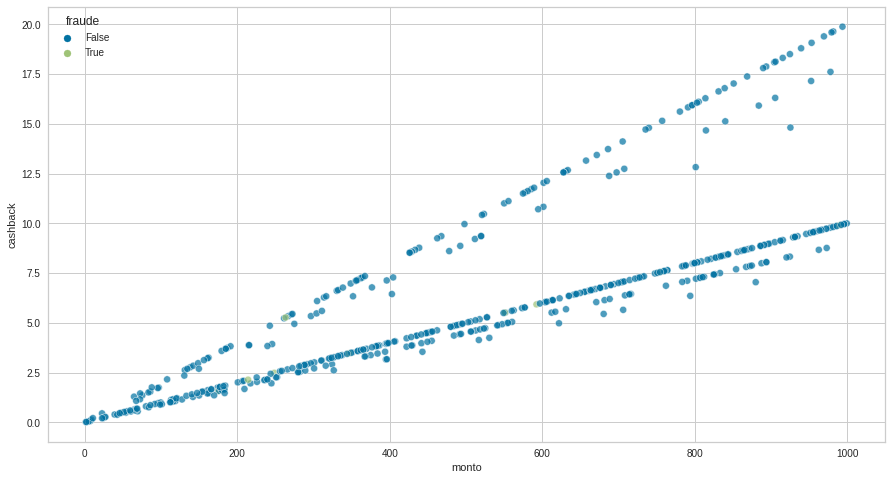

In [199]:
#Observamos si existe relación entre el monto, cashback y fraudes
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

sns.scatterplot(data = df.sample(500), x = 'monto', y = 'cashback',hue = 'fraude', s = 50, alpha = 0.7)

Podemos ver que existe una relación directa entre el monto y el cashback, pero que el cashback no es el mismo para todos los clientes, por lo que crearemos una nueva columna llamada percent_cashback.

In [200]:
#Creamos la nueva columna
df['percent_cashback'] = (df['cashback']/df['monto'])*100
df['percent_cashback'] = df.percent_cashback.round(1)
df.head()

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os,mes,año,percent_cashback
0,F,608.345633,2020-01-21,20,Super,Merida,Fisica,71000,51,Aceptada,False,60.834563,5.475111,False,2020,3,ANDROID,1,2020,0.9
2,F,790.037653,2020-01-17,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,2020,1,",",1,2020,2.0
3,F,767.005387,2020-05-01,11,MPago,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,7.670054,False,2020,3,WEB,5,2020,1.0
4,F,254.171053,2020-01-30,10,NaN,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,2.541711,False,2020,3,%%,1,2020,1.0
5,F,37.003747,2020-01-27,3,NaN,Guadalajara,Fisica,94000,56,Rechazada,False,0.000000,0.370037,False,2020,2,%%,1,2020,1.0


In [201]:
#Comprobamos que hay diferentes porcentajes de cashback por transacción
df.percent_cashback.unique()

array([0.9, 2. , 1. , 1.8, 1.6, 0.8])

In [202]:
#Creamos un subset de los fraudes en nuestro dataset
fraudes = df[df['fraude'] == True]

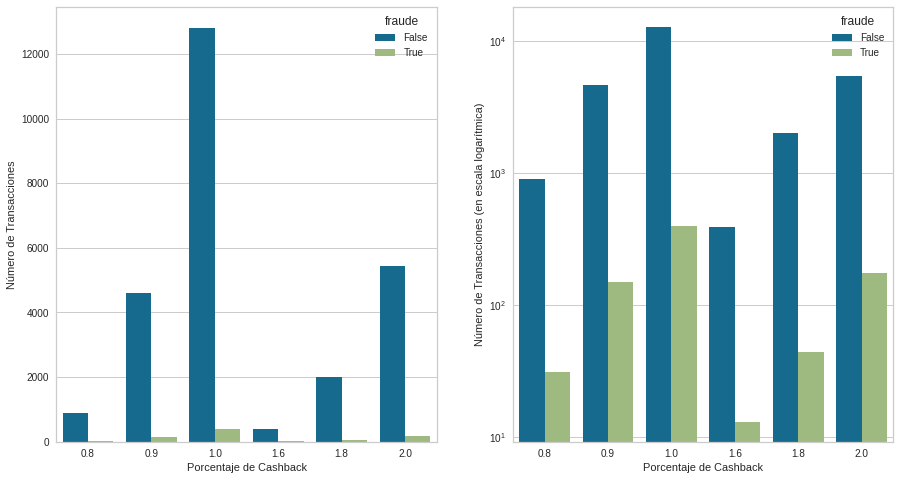

In [203]:
#Observamos la distribución de transacciones por porcentaje de cashback
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

plt.subplot(1,2,1)
count_cashback = sns.countplot(data = df, x = 'percent_cashback', hue = 'fraude')
plt.xlabel('Porcentaje de Cashback')
plt.ylabel('Número de Transacciones')

plt.subplot(1,2,2)
count_cashback = sns.countplot(data = df, x = 'percent_cashback', hue = 'fraude')
plt.xlabel('Porcentaje de Cashback')
plt.ylabel('Número de Transacciones (en escala logarítmica)')
count_cashback.set_yscale('log')

plt.show()

El porcentaje de cashback no parece influir significativamente, el número de fraudes tiende a ser proporcional a la cantidad de transacciones por cashback.

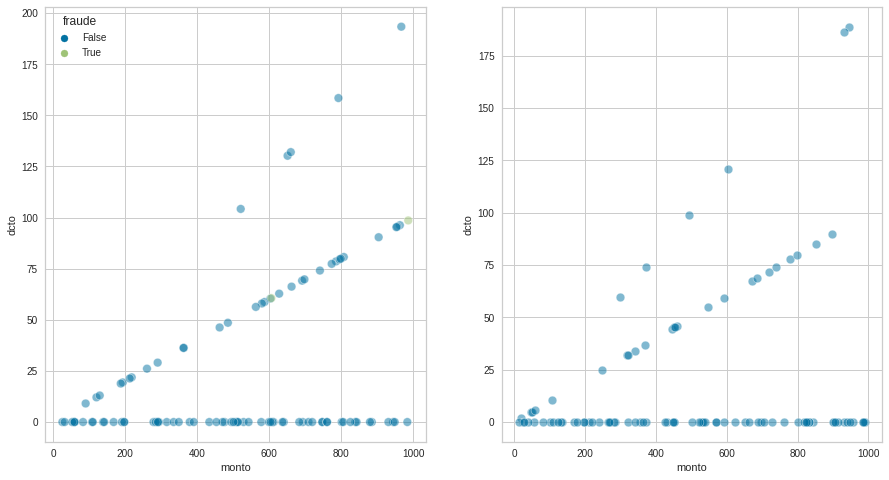

In [204]:
#Realizamos el mismo análisis, pero esta vez con montos y descuentos
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

#df
plt.subplot(1,2,1)
sns.scatterplot(data = df.sample(100), x = 'monto', y = 'dcto', hue = 'fraude',s = 75, alpha = 0.5)

#fraudes
plt.subplot(1,2,2)
sns.scatterplot(data = fraudes.sample(100), x = 'monto', y = 'dcto',s = 75, alpha = 0.5)

Observamos un patrón similar a los gráficos de cashback, por lo que crearemos la misma columna de porcentaje para monto.

In [205]:
#Creamos la columna
df['percent_disc'] = (df['dcto']/df['monto'])*100
df['percent_disc'] = df.percent_disc.round(1)

df.head()

,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_model,device_score,device_os,mes,año,percent_cashback,percent_disc
0,F,608.345633,2020-01-21,20,Super,Merida,Fisica,71000,51,Aceptada,False,60.834563,5.475111,False,2020,3,ANDROID,1,2020,0.9,10.0
2,F,790.037653,2020-01-17,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,2020,1,",",1,2020,2.0,0.0
3,F,767.005387,2020-05-01,11,MPago,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,7.670054,False,2020,3,WEB,5,2020,1.0,0.0
4,F,254.171053,2020-01-30,10,NaN,Guadalajara,Fisica,94000,56,Aceptada,False,0.000000,2.541711,False,2020,3,%%,1,2020,1.0,0.0
5,F,37.003747,2020-01-27,3,NaN,Guadalajara,Fisica,94000,56,Rechazada,False,0.000000,0.370037,False,2020,2,%%,1,2020,1.0,0.0


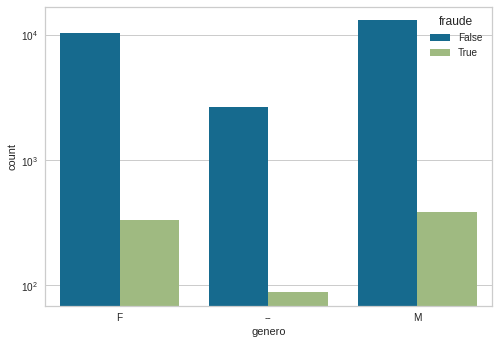

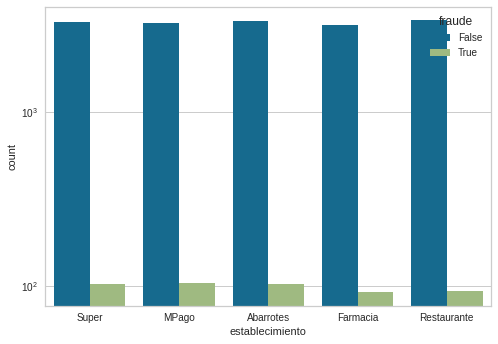

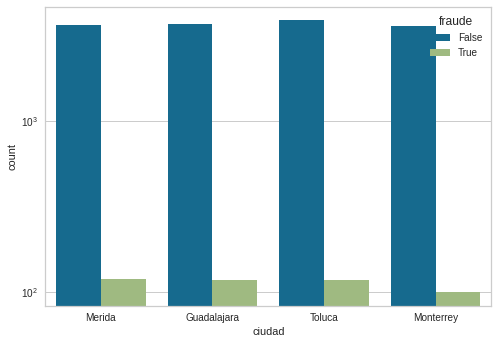

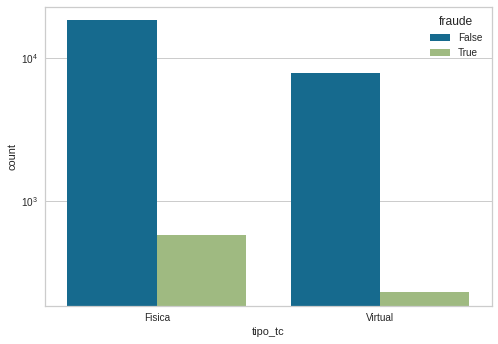

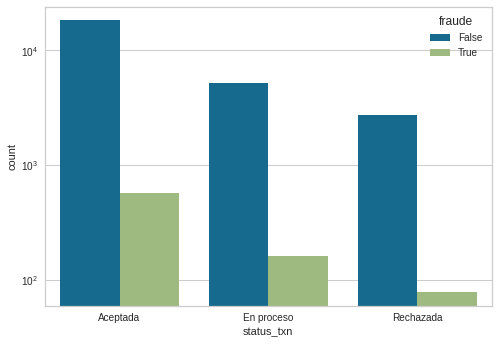

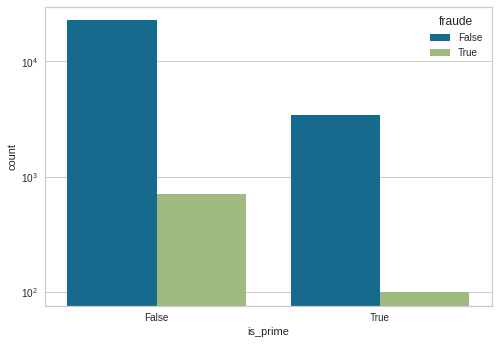

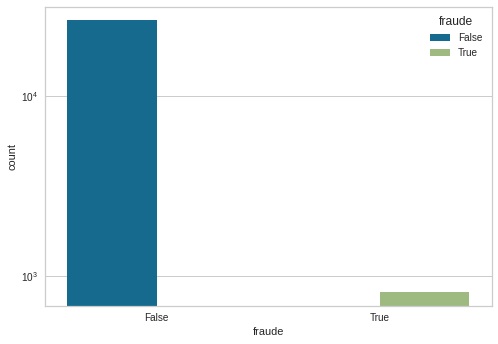

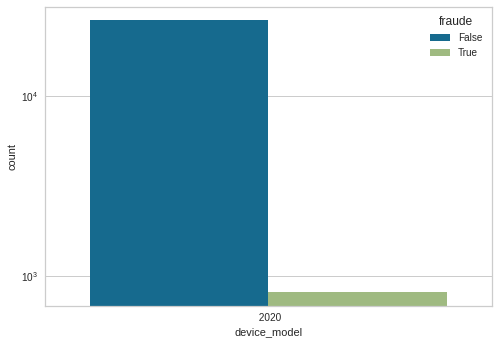

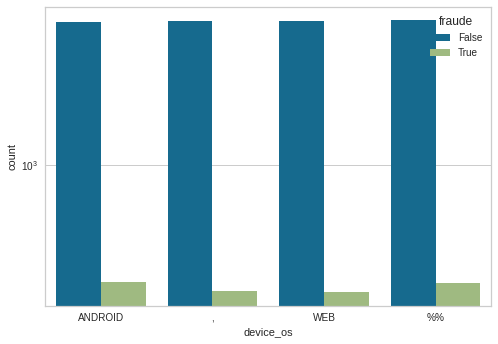

In [206]:
#Observamos si existe algún patrón en nuestras variables categóricas
df_1 = df.select_dtypes(['object','boolean'])

for i, col in enumerate(df_1):
    plt.figure(i)
    chart = sns.countplot(x = col, data = df_1, hue = 'fraude')
    chart.set_yscale('log')

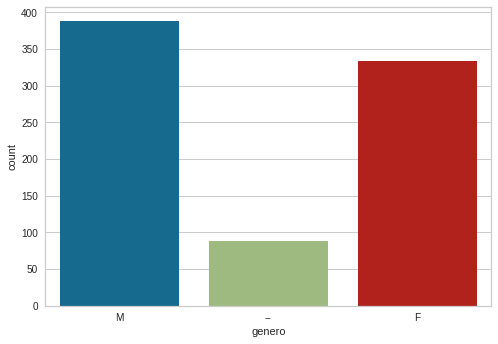

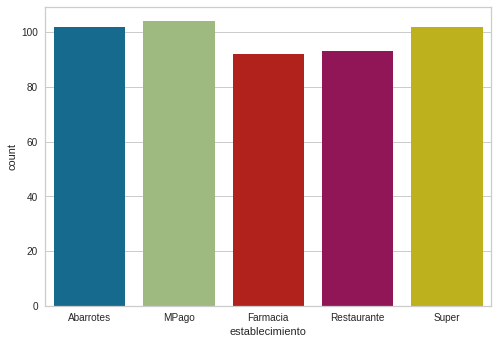

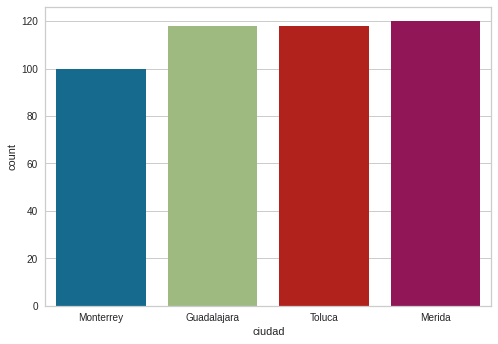

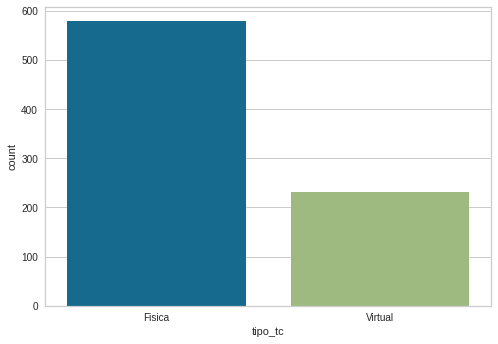

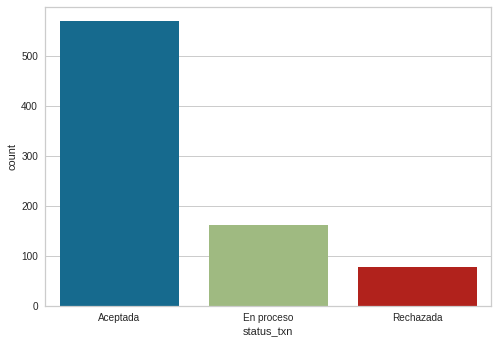

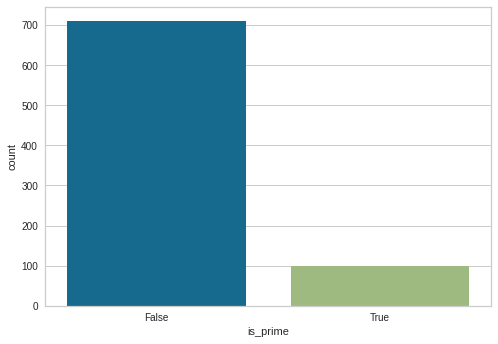

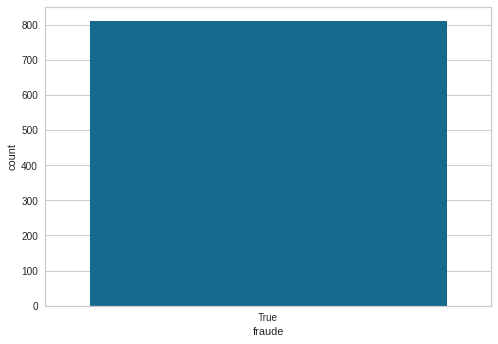

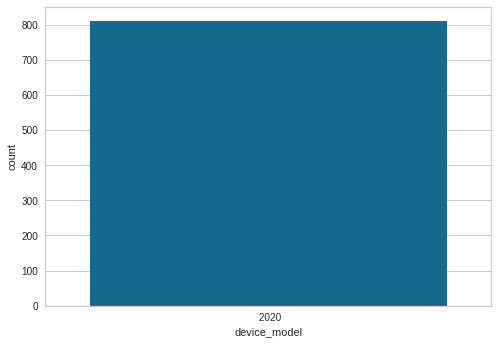

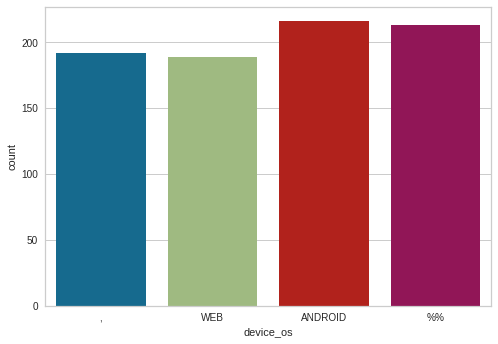

In [207]:
#Hacemos zoom in sólo en los fraudes
fraud_cols = fraudes.select_dtypes(['object','boolean'])

for i, col in enumerate(df_1):
    plt.figure(i)
    sns.countplot(x = col, data = fraud_cols)

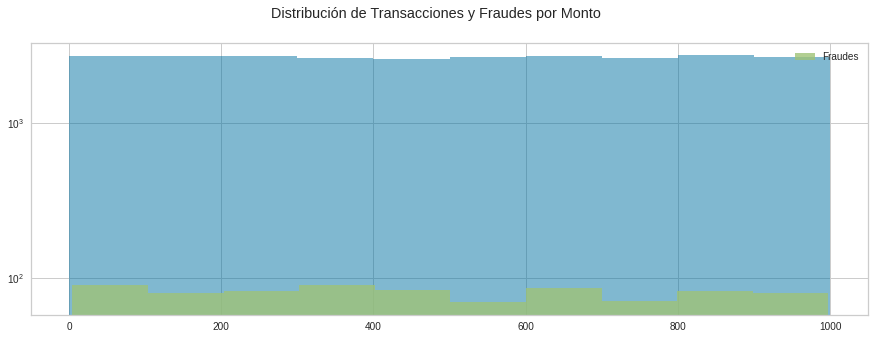

In [208]:
#Observamos cómo se distribuyen las transacciones regulares y fraudulentas por monto
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.monto, alpha = 0.5)
ax.hist(fraudes.monto, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Distribución de Transacciones y Fraudes por Monto')

plt.show()

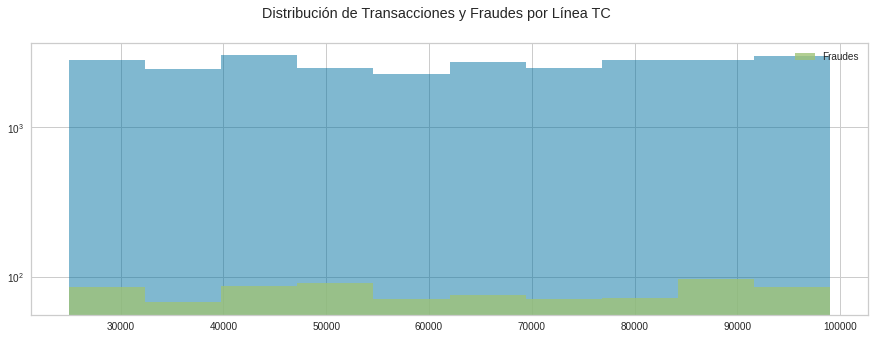

In [209]:
#Mismo para Línea TC
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.linea_tc, alpha = 0.5)
ax.hist(fraudes.linea_tc, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Distribución de Transacciones y Fraudes por Línea TC')

plt.show()

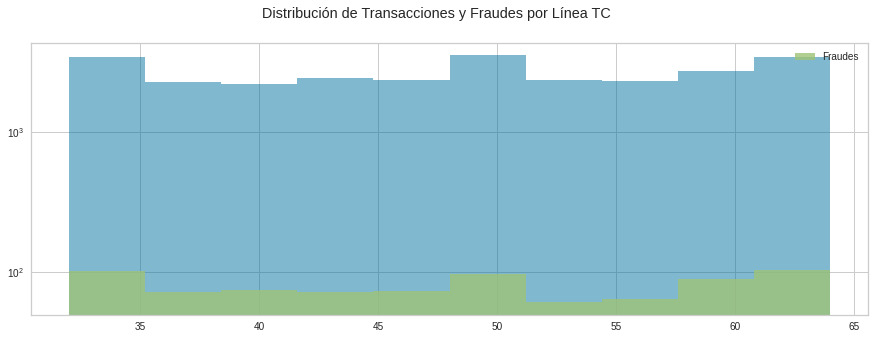

In [210]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

ax.hist(df.interes_tc, alpha = 0.5)
ax.hist(fraudes.interes_tc, alpha = 0.8, label = 'Fraudes')
ax.legend()
ax.set_yscale('log')
fig.suptitle('Distribución de Transacciones y Fraudes por Línea TC')

plt.show()

No parecen haber variaciones significativas en ambos gráficos

## Preparación del Dataset y Diseño del Modelo

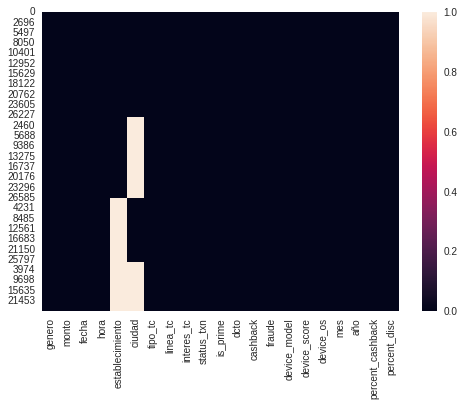

In [211]:
#Graficamos rápidamente los valores faltantes
sns.heatmap(df.isna().sort_values(by = ['establecimiento','ciudad']))

In [212]:
#Observamos qué porcentaje representan del total
null_totals = df.isnull().sum().sort_values(ascending = False)
percent_nulls = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_df = pd.concat([null_totals, percent_nulls], axis = 1, keys = ['total_nulls', 'percent_total'])

missing_df

,total_nulls,percent_total
ciudad,11678,0.432935
establecimiento,10118,0.375102
genero,0,0.000000
cashback,0,0.000000
percent_cashback,0,0.000000
año,0,0.000000
mes,0,0.000000
device_os,0,0.000000
device_score,0,0.000000
device_model,0,0.000000


In [213]:
#Sacamos las columnas con datos faltantes e irrelevantes
df.drop(columns = ['establecimiento','ciudad', 'device_model'], axis= 1, inplace = True)

In [214]:
#Comprobamos
df.head()

,genero,monto,fecha,hora,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,device_score,device_os,mes,año,percent_cashback,percent_disc
0,F,608.345633,2020-01-21,20,Fisica,71000,51,Aceptada,False,60.834563,5.475111,False,3,ANDROID,1,2020,0.9,10.0
2,F,790.037653,2020-01-17,11,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,1,",",1,2020,2.0,0.0
3,F,767.005387,2020-05-01,11,Fisica,94000,56,Aceptada,False,0.000000,7.670054,False,3,WEB,5,2020,1.0,0.0
4,F,254.171053,2020-01-30,10,Fisica,94000,56,Aceptada,False,0.000000,2.541711,False,3,%%,1,2020,1.0,0.0
5,F,37.003747,2020-01-27,3,Fisica,94000,56,Rechazada,False,0.000000,0.370037,False,2,%%,1,2020,1.0,0.0


In [215]:
#Codificamos la variable objetivo
encoder = OneHotEncoder(sparse = False)

result = encoder.fit_transform(df[['fraude']])
fraud_ = pd.DataFrame(result, columns = list(encoder.categories_[0]))

print(fraud_.value_counts())

df_ml = pd.concat([df, fraud_], axis = 1)

False  True
1.0    0.0     26164
0.0    1.0       810
dtype: int64


In [216]:
#Sacamos la columna de fraude
df_ml.drop(['fraude', False], axis = 1, inplace = True)

In [217]:
#Sacamos nuevamente los campos vacíos
df_ml.dropna(how = 'any', inplace = True)

In [218]:
#Renombramos para una manipulación más sencilla
df_ml = df_ml.rename({True:'is_True'}, axis = 1)

df_ml.head()

,genero,monto,fecha,hora,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,device_score,device_os,mes,año,percent_cashback,percent_disc,is_True
0,F,608.345633,2020-01-21,20.0,Fisica,71000.0,51.0,Aceptada,False,60.834563,5.475111,3.0,ANDROID,1.0,2020.0,0.9,10.0,0.0
2,F,790.037653,2020-01-17,11.0,Virtual,94000.0,56.0,En proceso,False,0.000000,15.800753,1.0,",",1.0,2020.0,2.0,0.0,0.0
3,F,767.005387,2020-05-01,11.0,Fisica,94000.0,56.0,Aceptada,False,0.000000,7.670054,3.0,WEB,5.0,2020.0,1.0,0.0,0.0
4,F,254.171053,2020-01-30,10.0,Fisica,94000.0,56.0,Aceptada,False,0.000000,2.541711,3.0,%%,1.0,2020.0,1.0,0.0,0.0
5,F,37.003747,2020-01-27,3.0,Fisica,94000.0,56.0,Rechazada,False,0.000000,0.370037,2.0,%%,1.0,2020.0,1.0,0.0,0.0


Ahora seleccionaremos las features que incorporaremos a nuestro modelo. En este caso, al ser un prototipo inicial para ser puesto en producción, sólo tomaremos las variables numéricas del dataset.

In [219]:
#Dividimos en Train y Test

x = df_ml[['monto', 'hora', 'percent_disc', 'percent_cashback', 'device_score', 'linea_tc', 'mes']]

y = df_ml[['is_True']]

y.value_counts()


x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 42)

In [220]:
#Observamos nuestro dataset de features
x.head()

,monto,hora,percent_disc,percent_cashback,device_score,linea_tc,mes
0,608.345633,20.0,10.0,0.9,3.0,71000.0,1.0
2,790.037653,11.0,0.0,2.0,1.0,94000.0,1.0
3,767.005387,11.0,0.0,1.0,3.0,94000.0,5.0
4,254.171053,10.0,0.0,1.0,3.0,94000.0,1.0
5,37.003747,3.0,0.0,1.0,2.0,94000.0,1.0


In [221]:
lr = LogisticRegression()

#sm = SMOTE(random_state= 7, sampling_strategy= 'auto')

#X_res, y_res = sm.fit_resample(x_train, y_train)

In [222]:
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [223]:
lr.score(x_test, y_test)

0.968564650059312

In [224]:
#lr.score(X_res, y_res)

In [225]:
y_prediction = lr.predict(x_test)

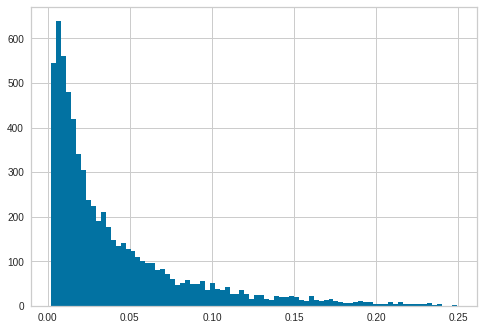

In [226]:
plt.hist(lr.predict_proba(x_test)[:,1], bins = round(np.sqrt(len(lr.predict_proba(x_test)[:,1]))))

plt.show()

In [227]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_prediction), columns = ['Predicted Legit', 'Predicted Fraud'], index = ['Actual Legit', 'Actual Fraud'])

,Predicted Legit,Predicted Fraud
Actual Legit,6532,0
Actual Fraud,212,0


In [228]:
#Guardamos el modelo
filename = 'logistic_regression_model.pkl'
pickle.dump(lr, open(filename, 'wb'))